# Data Profiling, Cleaning & EDA-Sierraleone
**Objective:** Profile, clean, and explore the solar dataset for Sierraleone so it’s ready for comparison and region-ranking tasks.

This notebook includes:
- Summary statistics and missing-value report
- Outlier detection and cleaning
- Time series analysis
- Correlation and scatter plots
- Wind and temperature analysis
- Bubble charts

## Importing the dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Loading the Data

In [ ]:
# Set both plotting and display settings
import pandas as pd

# Load dataset
df = pd.read_csv(r"D:\Python\Week_01\data\data\sierraleone-bumbuna.csv")

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 10)

In [ ]:
# Show basic info
print(f"Dataset shape: {df.shape}")
df.info()

In [ ]:
#  Display the first 5 rows
print("\nFirst 5 rows:")
display(df.head())

In [ ]:
# Display the last 10 rows
print("\nLast 10 rows:")
display(df.tail(10))

In [ ]:
# Display 10 random sample rows
print("\nRandom sample of 10 rows:")
display(df.sample(10, random_state=42))

## Summary statistics and missing-value report

In [ ]:
# Summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
display(df.describe())

In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Percentage of missing values per column
null_percent = df.isna().mean() * 100
print("\nPercentage of missing values:")
print((null_percent).round(2))

# Filter columns with more than 5% nulls
cols_with_nulls = null_percent[null_percent > 5].index.tolist()
print("\nColumns with >5% nulls:", cols_with_nulls)

# Exact duplicate rows
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)



## Interpretation of Summary statistics and missing-value report

### 1. **General Overview**
- The dataset has 525,600 records — suggests 60 min × 24 hr × 365 days = 1 year of minute-level data.
- No missing numerical data (count = 525,600 for all measured variables).
- Comments column is empty (count = 0); can be dropped
- **Solar data (GHI, DNI, DHI)**: Negative GHI/DNI/DHI values are incorrect entries or sensor noise need correction
- **Module data (ModA, ModB)**: Consistent with irradiance
- **Temperature (Tamb, TModA, TModB)**: Physically valid
- **Humidity (RH)**: Reasonable; 9.9 %(min) low outlier may indicate a dry period or sensor drift.
- **Wind (WS, WSgust, WSstdev, WD, WDstdev)**: Wind readings are consistent; no clear data errors.
- **Pressure (BP)**: Normal atmospheric range at moderate altitude
- **Flags(Cleaning Flag & Precipitation)**: Sparse cleaning events → panels mostly uncleaned., no issues

## Univariate Analysis for Numeric Columns Only

In [ ]:
# Look for missing values, outliers, incorrect entries
cols_radiation = ['GHI', 'DNI', 'DHI']
cols_sensor = ['ModA', 'ModB']
cols_wind = ['WS', 'WSgust']
cols_misc = ['Cleaning', 'Precipitation']

all_cols = cols_radiation + cols_sensor + cols_wind + cols_misc
# Function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] < lower) | (df[column] > upper)]

# Outliers summary
print("\nNumber of outliers per column:")
for col in all_cols:
    outliers = detect_outliers(df, col)
    print(f"{col}: {len(outliers)}")

# Flag incorrect entries
df_flags = pd.DataFrame(index=df.index)
df_flags['Negative_Radiation'] = (df[cols_radiation] < 0).any(axis=1)
df_flags['Negative_Wind'] = (df[cols_wind] < 0).any(axis=1)
df_flags['Invalid_Cleaning'] = ~df['Cleaning'].isin([0, 1])
df_flags['Negative_Precipitation'] = df['Precipitation'] < 0

print("\nRows with flagged incorrect entries:")
print(df_flags[df_flags.any(axis=1)])

# Compute Z-scores and flag extreme values |Z|>3

cols_zscore = cols_radiation + cols_sensor + cols_wind
df_zscores = df[cols_zscore].apply(zscore)

# Flag extreme values
extreme_flags = (np.abs(df_zscores) > 3)
print("\nNumber of extreme Z-score values per column:")
print(extreme_flags.sum())

# view rows with any extreme Z-score
extreme_rows = df[extreme_flags.any(axis=1)]
print("\nRows with extreme Z-scores (|Z|>3):")
print(extreme_rows)

# Handle missing values
# Option 1: Drop rows with missing values in key columns
# df_cleaned = df.dropna(subset=cols_radiation + cols_sensor + cols_wind)

# Option 2: Impute missing values using median
df_imputed = df.copy()
for col in cols_radiation + cols_sensor + cols_wind + ['Precipitation']:
    median_value = df_imputed[col].median()
    #df_imputed[col].fillna(median_value, inplace=True)
    df_imputed[col] = df_imputed[col].fillna(median_value)

# Verify missing values are handled
print("\nMissing values after imputation:")
print(df_imputed[all_cols].isna().sum())
# visualize distributions and outliers
# ---------------------------

for col in all_cols:
    plt.figure(figsize=(12, 4))

    # Histogram on the left
    plt.subplot(1, 2, 1)
    sns.histplot(df_imputed[col], bins=50, kde=True, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot on the right
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_imputed[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

    plt.tight_layout()
    plt.show()



### Interpretation of Box plot and Histogram Report
1. GHI, DNI, DHI (Radiation Columns)
Histogram Interpretation:
•	Usually right-skewed because there are many low values (nighttime) and fewer high values (midday).
•	Peaks around solar noon if data is from daytime.
•	Any negative values would be physically impossible → indicate sensor error.
Boxplot Interpretation:
•	Median near the central value of daytime radiation.
•	Outliers: extremely high spikes could indicate sensor glitches.
•	Values below 0 should be flagged.

2. ModA, ModB (Sensor Readings)
Histogram Interpretation:
•	Often roughly normal if sensors behave consistently.
•	Peaks indicate common operating ranges.
•	Bimodal or irregular shapes can signal malfunction or calibration issues.
Boxplot Interpretation:
•	Outliers: unusually high or low readings may indicate sensor errors.
•	Check symmetry: large deviations on one side may suggest drift.
________________________________________
3. WS, WSgust (Wind Speed)
Histogram Interpretation:
•	Usually right-skewed: most readings are low, occasional gusts are high.
•	Negative values are physically impossible → must be flagged.
Boxplot Interpretation:
•	Outliers represent strong gusts.
•	Median and quartiles help understand typical wind conditions.
•	If the box is very narrow, the sensor may not be capturing variability well.
________________________________________
4. Cleaning (1 or 0)
Histogram Interpretation:
•	Only two bars at 0 and 1.
•	Shows frequency of cleaning events.
Boxplot Interpretation:
•	With only two unique values, boxplot is not very informative.
•	Any values other than 0 or 1 are invalid → need correction.
________________________________________
5. Precipitation (mm/min)
Histogram Interpretation:
•	Highly right-skewed: most minutes have no rain (0), occasional high rainfall minutes create a long tail.
•	Negative values are impossible → indicate errors.
Boxplot Interpretation:
•	Outliers correspond to intense rain events.
•	Median is likely 0 or very low, reflecting mostly dry periods.
________________________________________
Summary of What to Look For
1.	From Histograms:
o	Distribution shape → normal, skewed, bimodal
o	Peaks → typical values
o	Impossible values (negative for radiation, wind, precipitation)
2.	From Boxplots:
o	Outliers → unusually high or low values
o	Median & quartiles → typical operating range
o	Flags potential sensor errors


## Cleaning the Data

In [ ]:
from scipy.stats import zscore

# Define relevant columns for cleaning
cols_radiation = ['GHI', 'DNI', 'DHI']
cols_sensor = ['ModA', 'ModB']
cols_wind = ['WS', 'WSgust']
cols_misc = ['Cleaning', 'Precipitation']

cols_numeric_for_impute = cols_radiation + cols_sensor + cols_wind + ['Precipitation']
cols_for_zscore = cols_radiation + cols_sensor + cols_wind

# ---------------------------
#  Handle missing values: Impute median for key numeric columns
# ---------------------------
df_cleaned = df.copy()

for col in cols_numeric_for_impute:
    median_value = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_value)

# For Cleaning, fill missing with 0 (assuming no cleaning event if missing)
df_cleaned['Cleaning'] = df_cleaned['Cleaning'].fillna(0)

# ---------------------------
# Remove impossible values
# ---------------------------
# Negative values for radiation, wind, precipitation
df_cleaned = df_cleaned[(df_cleaned[cols_radiation] >= 0).all(axis=1)]
df_cleaned = df_cleaned[(df_cleaned[cols_wind] >= 0).all(axis=1)]
df_cleaned = df_cleaned[df_cleaned['Precipitation'] >= 0]

# Ensure Cleaning is only 0 or 1
df_cleaned = df_cleaned[df_cleaned['Cleaning'].isin([0, 1])]

# ---------------------------
# Remove extreme outliers using Z-score (|Z|>3)
# ---------------------------
z_scores = df_cleaned[cols_for_zscore].apply(zscore)

# Keep rows where all Z-scores are within ±3
df_cleaned = df_cleaned[(np.abs(z_scores) <= 3).all(axis=1)]

# ---------------------------
# Export cleaned dataset (all columns included)
# ---------------------------
output_path = r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\sierralione_clean.csv"
df_cleaned.to_csv(output_path, index=False)

print(f"Cleaned dataset exported to: {output_path}")
print(f"Original rows: {len(df)}, Cleaned rows: {len(df_cleaned)}")


## Bivariate Analysis
### Time Series Analysis

Columns available: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']


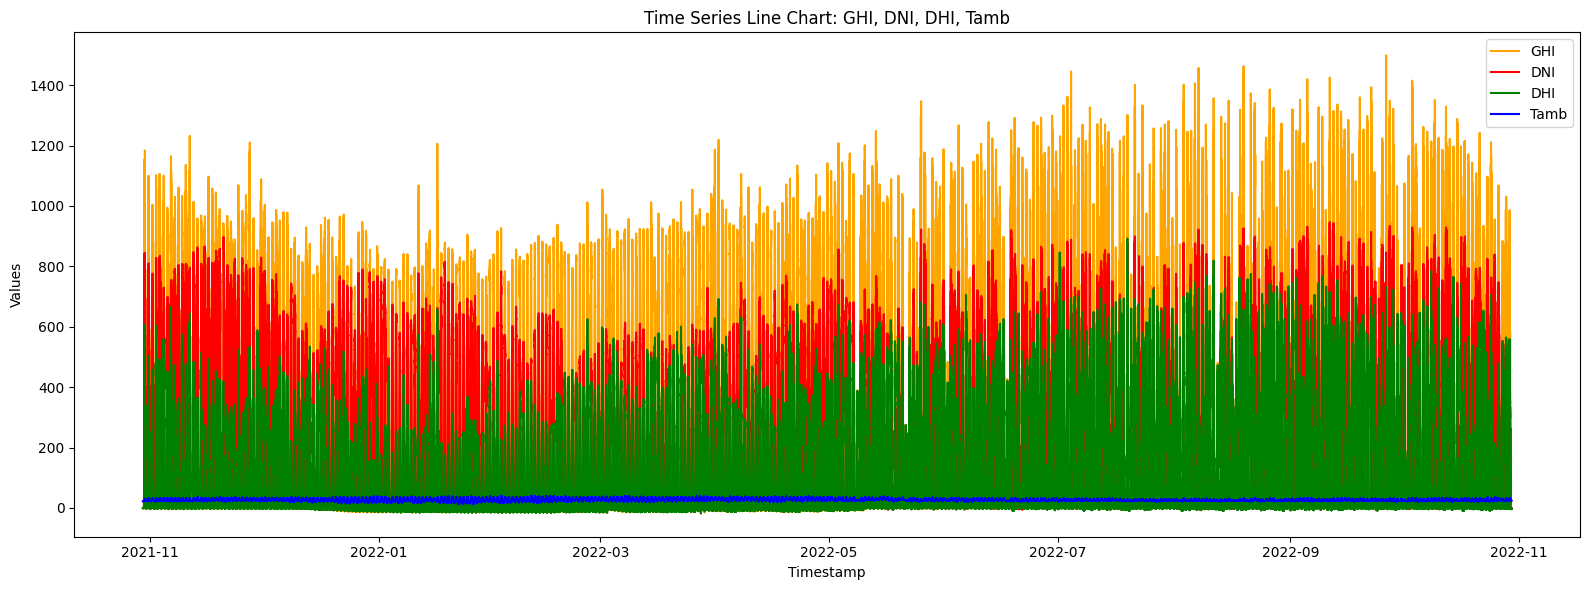

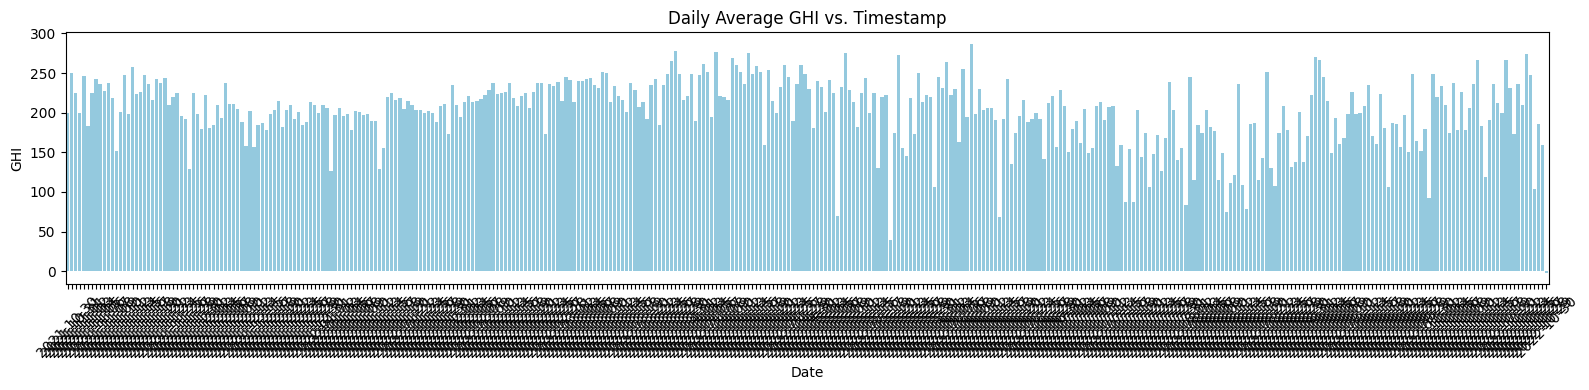

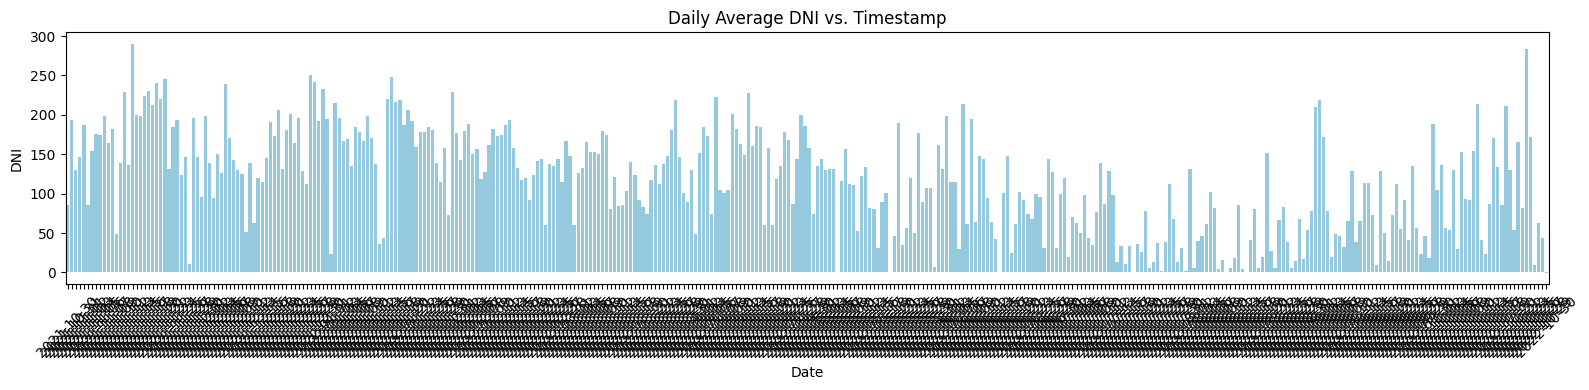

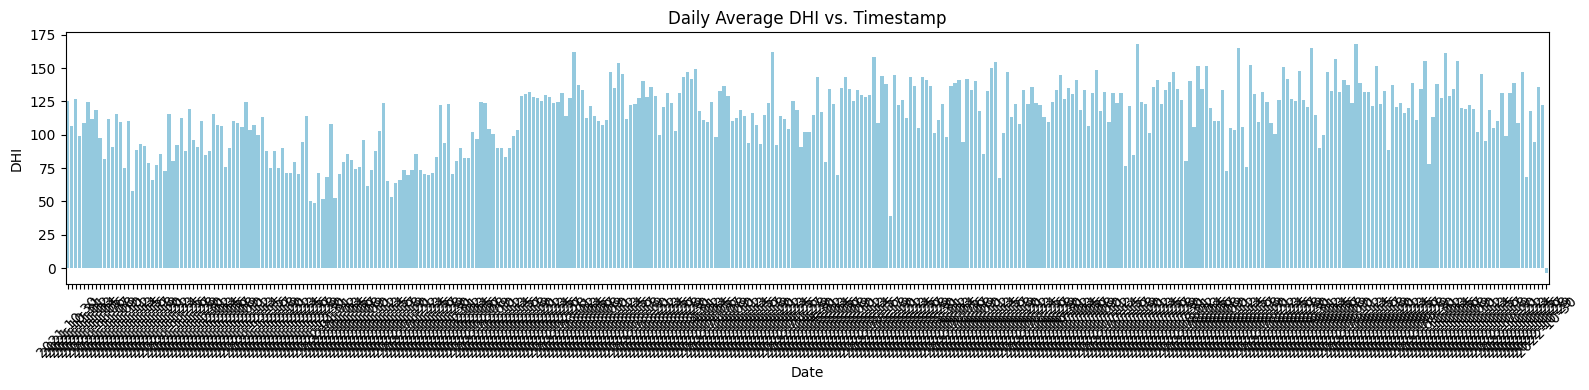

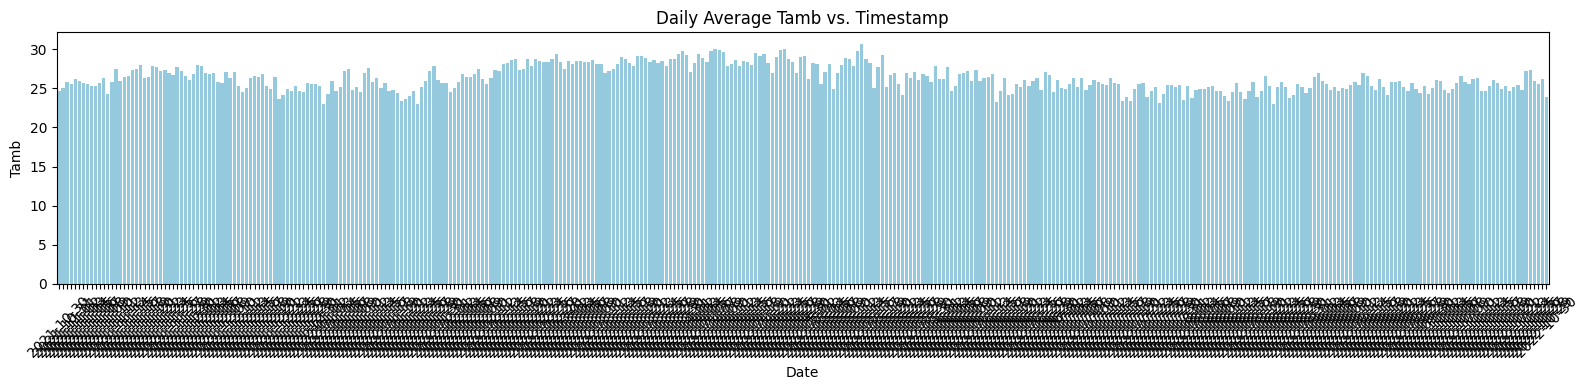

In [ ]:
df = pd.read_csv(r"D:\Python\Week_01\data\data\sierraleone-bumbuna.csv")# Strip extra spaces in column names
df.columns = df.columns.str.strip()

# Check columns
print("Columns available:", df.columns.tolist())

# Ensure Timestamp column exists and convert to datetime
if 'Timestamp' not in df.columns:
    raise KeyError("Column 'Timestamp' not found in the dataset. Check column names.")

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Drop rows where Timestamp could not be parsed
df = df.dropna(subset=['Timestamp'])

# Sort by Timestamp
df = df.sort_values('Timestamp')

# Set Timestamp as index (optional but useful for plotting)
df.set_index('Timestamp', inplace=True)

# ---------------------------
# 2️⃣ Line chart for GHI, DNI, DHI, Tamb
# ---------------------------
plt.figure(figsize=(16, 6))
for col, color in zip(['GHI', 'DNI', 'DHI', 'Tamb'], ['orange', 'red', 'green', 'blue']):
    if col in df.columns:
        plt.plot(df.index, df[col], label=col, color=color)
    else:
        print(f"Warning: Column '{col}' not found in dataset.")
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Time Series Line Chart: GHI, DNI, DHI, Tamb')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# 3️⃣ Optional: Bar charts (daily average)
# ---------------------------
# Resample to daily averages
df_daily = df.resample('D').mean()

for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    if col in df_daily.columns:
        plt.figure(figsize=(16, 4))
        sns.barplot(x=df_daily.index, y=df_daily[col], color='skyblue')
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Daily Average {col} vs. Timestamp')
        plt.show()

### Observe patterns by month, trends throughout the day, or anomalies, such as peaks in solar irradiance or temperature fluctuations. 